# <center>Task2: Movie Recommender</center>

#### The dataset contains samples of movies watched by users and their ratings provided by the users. We will analyse and find relations with the help of movies and ratings data given by the user to recommend a set of movies based on the previous movies watched by the user.

In [3]:
%matplotlib inline 

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Loading the Datasets.

df_rating = pd.read_csv('dataset/ratings_small.csv')
df_movie = pd.read_csv('dataset/movies_metadata.csv')

# Exploring the Datasets.

In [5]:
print(df_movie.shape)
df_movie.tail(5)

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0
45465,False,NaN,0,[],NaN,461257,tt6980792,en,Queerama,50 years after decriminalisation of homosexual...,...,2017-06-09,0.0,75.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Queerama,False,0.0,0.0


#### The df_movie contains all the information about movie including ite title, revenue, status, vote_count etc.

In [6]:
print(df_rating.shape)
df_rating.head(2)

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


#### This dataframe contains information about the users rating they have given for each movie. This data contains user_id and movie_id for which user has given a rating at a specific timestamp.

In [7]:
len(set(df_rating.userId))

671

We can see that there are 671 total users who has given movie ratings.

### Plotting the Ratings

Text(0.5, 0, 'Movie Ratings')

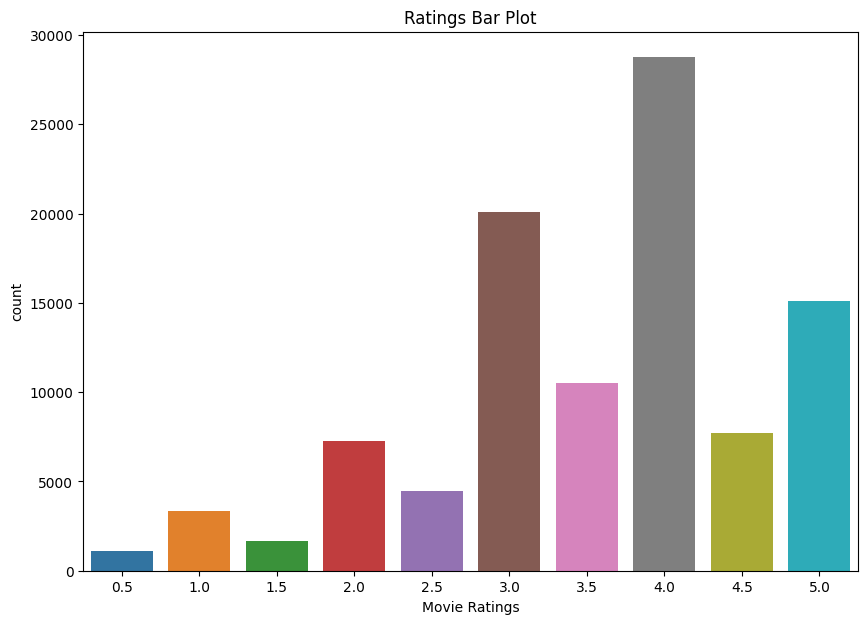

In [8]:
plt.figure(figsize=(10,7))
ax = sns.countplot(data=df_rating, x='rating')
plt.title('Ratings Bar Plot')
plt.xlabel('Movie Ratings')

### Average rating of Movies

In [9]:
round(df_rating.rating.mean(), 2)

3.54

As we can see, most of the users have given 4 rating to the movies, a vert less number of movies that has been given rating. This might be because of many reasons. We should keep these movies into account and shouldn't recommend these movies to our customers. </br>
The average rating for the movies is <b>3.54</b>

In [10]:
df_rating.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [11]:
df_movie.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

#### There are 6 movies, that doesn't have any title, and hence these can't be used in the recommendation system. We will remove these samples from our dataset.

In [12]:
print('Before removing rows with no title', df_movie.shape)

Before removing rows with no title (45466, 24)


In [13]:
# Removing the samples with No title information.

df_movie = df_movie[df_movie['title'].notna()]
print('After removing rows with no title', df_movie.shape)

After removing rows with no title (45460, 24)


### Total number of Unique movies in the movies dataframe

In [14]:
print(f"There are {len(set(df_movie.title))}")

There are 42277


In [15]:
# converting the id column of df_movie as it is in string format.
df_movie['id'] = df_movie.id.apply(lambda x: int(x))

In [16]:
merged_df = pd.merge(df_rating, df_movie, left_on='movieId', right_on='id')
merged_df.head()

,userId,movieId,rating,timestamp,adult,belongs_to_collection,budget,genres,homepage,id,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,1,1371,2.5,1260759135,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
1,4,1371,4.0,949810302,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
2,7,1371,3.0,851869160,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
3,19,1371,4.0,855193404,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
4,21,1371,3.0,853852263,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0


In [17]:
merged_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'adult',
       'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

We don't need all the columns to build a movie recommender system. Hence, we will remove all the other columns that are not required for our task and will only keep the necessary columns such as userId, movieId, rating and title.

In [18]:
chunk_df = merged_df[['userId', 'movieId', 'title', 'rating']]

In [19]:
print('The shape of chunk_df is', chunk_df.shape)
chunk_df.head()

The shape of chunk_df is (44994, 4)


,userId,movieId,title,rating
0,1,1371,Rocky III,2.5
1,4,1371,Rocky III,4.0
2,7,1371,Rocky III,3.0
3,19,1371,Rocky III,4.0
4,21,1371,Rocky III,3.0


In [20]:
print('The shape of chunk_df is after removing duplicate values is', chunk_df.shape)
chunk_df = chunk_df.drop_duplicates(['userId','title'])

The shape of chunk_df is after removing duplicate values is (44994, 4)


In [21]:
pivoted_df = chunk_df.pivot(index='userId', columns='title', values='rating').fillna(0)

In [22]:
pivoted_df.head(3)

title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...And God Created Woman,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,...,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,Zozo,eXistenZ,xXx,¡Three Amigos!,À nos amours,Ödipussi,Şaban Oğlu Şaban
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The values in the dataframe are in float format and apriori accepts only integer values. We have to convert the values of this pivoted_df to integer type.

In [23]:
pivoted_df = pivoted_df.astype('int64')
pivoted_df = pivoted_df.applymap(lambda x: 0 if x<=0 else 1)

In [24]:
pivoted_df.head()

title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...And God Created Woman,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,...,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,Zozo,eXistenZ,xXx,¡Three Amigos!,À nos amours,Ödipussi,Şaban Oğlu Şaban
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
most_occuring_movies = apriori(pivoted_df, min_support=0.07, use_colnames=True)

In [26]:
most_occuring_movies.head()

,support,itemsets
0,0.129657,"(20,000 Leagues Under the Sea)"
1,0.129657,(2001: A Space Odyssey)
2,0.298063,(48 Hrs.)
3,0.292101,(5 Card Stud)
4,0.093890,(A Brief History of Time)


#### The Apriori algorithms has given us the Support for each movie.

In [27]:
movie_rules = association_rules(most_occuring_movies, metric="lift", min_threshold=1)

In [28]:
movie_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(48 Hrs.),"(20,000 Leagues Under the Sea)",0.298063,0.129657,0.076006,0.255000,1.966724,0.037360,1.168245
1,"(20,000 Leagues Under the Sea)",(48 Hrs.),0.129657,0.298063,0.076006,0.586207,1.966724,0.037360,1.696349
2,"(20,000 Leagues Under the Sea)",(A Nightmare on Elm Street),0.129657,0.266766,0.081967,0.632184,2.369807,0.047379,1.993480
3,(A Nightmare on Elm Street),"(20,000 Leagues Under the Sea)",0.266766,0.129657,0.081967,0.307263,2.369807,0.047379,1.256382
4,(Back to the Future Part II),"(20,000 Leagues Under the Sea)",0.210134,0.129657,0.077496,0.368794,2.844379,0.050251,1.378858


In [30]:
final_results_with_lift = movie_rules.sort_values(by=['lift'], ascending=False)
final_results_with_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
70959,(On Guard),"(The Garden of Eden, Muxmäuschenstill)",0.087928,0.099851,0.070045,0.796610,7.977991,0.061265,4.425733
70958,"(The Garden of Eden, Muxmäuschenstill)",(On Guard),0.099851,0.087928,0.070045,0.701493,7.977991,0.061265,3.055440
197232,"(Rope, Big Fish)","(All the Way Boys, Psycho)",0.092399,0.095380,0.070045,0.758065,7.947833,0.061232,3.739096
197237,"(All the Way Boys, Psycho)","(Rope, Big Fish)",0.095380,0.092399,0.070045,0.734375,7.947833,0.061232,3.416849
2541145,"(Cockles and Muscles, 48 Hrs., A Nightmare on ...","(Back to the Future Part II, Rain Man, Sissi, ...",0.093890,0.098361,0.071535,0.761905,7.746032,0.062300,3.786885


---

# Building the Recommender Function

In [31]:
def recommender(movie_name=None):
    try:
        selected_movie_df = final_results_with_lift[final_results_with_lift['antecedents'].apply(lambda x: len(x) ==1 and next(iter(x)) == movie_name)]
        filtered_lift_df = selected_movie_df.loc[selected_movie_df['lift'] >= 1]
        final_movies_list = filtered_lift_df['consequents'].values
        final_movie_set = set()
        
        for mov in final_movies_list:
            for tit in mov:
                final_movie_set.add(tit)
        
        if final_movie_set:
            print(f'##########THE RECOMMENDED MOVIES FOR {movie_name} are##########')
        else:
            print(f"Aah Aah...Sorry, We don't have any recoomendations for {movie_name}")
        
        
        for ind, i in enumerate(list(final_movie_set)[:5], start=1):print(f"{ind}. {i}")
        
        return filtered_lift_df.head(5)
    
    except Exception as e:
        print('Something went wrong in the recommender system. Please try with some other movie name.')

---

### Trying the Recommender for <i> Jarhead </i> movie.

In [32]:
recommender(movie_name='Jarhead')

##########THE RECOMMENDED MOVIES FOR Jarhead are##########
1. Solaris
2. 48 Hrs.
3. The Million Dollar Hotel
4. Sissi
5. The Passion of Joan of Arc


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8907,(Jarhead),"(48 Hrs., Men in Black II)",0.149031,0.135618,0.070045,0.47,3.465604,0.049833,1.630909
3328,(Jarhead),(Judgment Night),0.149031,0.154993,0.077496,0.52,3.355000,0.054398,1.760432
56667,(Jarhead),"(Men in Black II, Sleepless in Seattle)",0.149031,0.162444,0.073025,0.49,3.016422,0.048816,1.642266
351756,(Jarhead),"(Men in Black II, The Million Dollar Hotel, Te...",0.149031,0.169896,0.070045,0.47,2.766404,0.044725,1.566235
56697,(Jarhead),"(Men in Black II, The Passion of Joan of Arc)",0.149031,0.174367,0.070045,0.47,2.695470,0.044059,1.557799


#### As we can see, the first top 5 movies that a user might like to see for the movie Jarhead.

---

### Trying the Recommender for <i> Solaris </i> movie.

In [33]:
recommender(movie_name='Solaris')

##########THE RECOMMENDED MOVIES FOR Solaris are##########
1. Back to the Future Part II
2. Silent Light
3. Contempt
4. Dawn of the Dead
5. 2001: A Space Odyssey


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1163266,(Solaris),"(The Tunnel, Monsoon Wedding, Men in Black II,...",0.450075,0.076006,0.076006,0.168874,2.221854,0.041798,1.111738
1163506,(Solaris),"(The Tunnel, Monsoon Wedding, Men in Black II,...",0.450075,0.071535,0.071535,0.158940,2.221854,0.039339,1.103923
2217870,(Solaris),"(Sissi, Titanic, Terminator 3: Rise of the Mac...",0.450075,0.071535,0.071535,0.158940,2.221854,0.039339,1.103923
2217312,(Solaris),"(Sissi, The Conversation, Terminator 3: Rise o...",0.450075,0.071535,0.071535,0.158940,2.221854,0.039339,1.103923
1248165,(Solaris),"(The Cave of the Yellow Dog, Monsoon Wedding, ...",0.450075,0.070045,0.070045,0.155629,2.221854,0.038519,1.101359


#### We can see, the first top 5 movies that a user might like to see for the movie Solaris.

---

### Trying the Recommender for <i> Terminator 3: Rise of the Machines </i> movie.

In [35]:
recommender(movie_name='Terminator 3: Rise of the Machines')

##########THE RECOMMENDED MOVIES FOR Terminator 3: Rise of the Machines are##########
1. Back to the Future Part II
2. Silent Light
3. Zatoichi
4. Contempt
5. Dawn of the Dead


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
428535,(Terminator 3: Rise of the Machines),"(Point Break, Titanic, The Passion of Joan of ...",0.481371,0.070045,0.070045,0.145511,2.077399,0.036327,1.088317
1271209,(Terminator 3: Rise of the Machines),"(Say Anything..., The Talented Mr. Ripley, Poi...",0.481371,0.071535,0.071535,0.148607,2.077399,0.037100,1.090524
428549,(Terminator 3: Rise of the Machines),"(Young and Innocent, Point Break, The Passion ...",0.481371,0.071535,0.071535,0.148607,2.077399,0.037100,1.090524
427553,(Terminator 3: Rise of the Machines),"(Point Break, Sleepless in Seattle, Sissi)",0.481371,0.070045,0.070045,0.145511,2.077399,0.036327,1.088317
428577,(Terminator 3: Rise of the Machines),"(Young and Innocent, Point Break, The Talented...",0.481371,0.080477,0.080477,0.167183,2.077399,0.041738,1.104111


#### We can see, the first top 5 movies that a user might like to see for the movie Terminator 3: Rise of the Machines.

---

# <center>End of Notebook</center>

---